In [28]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import numpy as np

In [29]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [53]:
df1 = read_csv('merge_oil.csv', header=0, index_col=0)
df1 = df1[["Price","US_Price","Dollar_eq","Open","High","Low","Volume","Percent_Change"]]
print(df1.head())
values = df1.values

values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
#print(reframed.head())
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

    Price  US_Price  Dollar_eq    Open    High     Low    Volume  \
0  5152.0     71.12      72.36  5066.0  5163.0  5063.0  123550.0   
1  5055.0     69.85      72.71  4983.0  5118.0  4962.0  144670.0   
2  4995.0     68.91      72.54  4987.0  5049.0  4965.0  122280.0   
3  4950.0     68.99      71.88  4930.0  5025.0  4888.0  143400.0   
4  5085.0     70.37      72.16  5050.0  5140.0  5020.0  155090.0   

   Percent_Change  
0            1.92  
1            1.20  
2            0.91  
3            0.65  
4            0.81  
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.584143   0.532614   0.985477   0.573062   0.554933   0.591074   
2   0.567014   0.517552   1.000000   0.558235   0.547292   0.572750   
3   0.556419   0.506404   0.992946   0.558950   0.535575   0.573295   
4   0.548473   0.507353   0.965560   0.548767   0.531499   0.559325   
5   0.572311   0.523719   0.977179   0.570204   0.551027   0.583273   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.29

In [54]:
values = reframed.values
#print(values)
split = int(len(list(df1["Price"]))*0.8)
train = values[:split,:]
test = values[split:,:]
train_X,train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
#print(test_y)

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1326, 1, 8) (1326,) (331, 1, 8) (331,)


Train on 1326 samples, validate on 331 samples
Epoch 1/50
 - 2s - loss: 0.2560 - val_loss: 0.2662
Epoch 2/50
 - 0s - loss: 0.1315 - val_loss: 0.1148
Epoch 3/50
 - 0s - loss: 0.1113 - val_loss: 0.0615
Epoch 4/50
 - 0s - loss: 0.0913 - val_loss: 0.0426
Epoch 5/50
 - 0s - loss: 0.0662 - val_loss: 0.0244
Epoch 6/50
 - 0s - loss: 0.0394 - val_loss: 0.0231
Epoch 7/50
 - 0s - loss: 0.0187 - val_loss: 0.0210
Epoch 8/50
 - 0s - loss: 0.0239 - val_loss: 0.0236
Epoch 9/50
 - 0s - loss: 0.0177 - val_loss: 0.0204
Epoch 10/50
 - 0s - loss: 0.0218 - val_loss: 0.0222
Epoch 11/50
 - 0s - loss: 0.0188 - val_loss: 0.0177
Epoch 12/50
 - 0s - loss: 0.0255 - val_loss: 0.0224
Epoch 13/50
 - 0s - loss: 0.0139 - val_loss: 0.0213
Epoch 14/50
 - 0s - loss: 0.0216 - val_loss: 0.0205
Epoch 15/50
 - 0s - loss: 0.0179 - val_loss: 0.0177
Epoch 16/50
 - 0s - loss: 0.0245 - val_loss: 0.0195
Epoch 17/50
 - 0s - loss: 0.0143 - val_loss: 0.0271
Epoch 18/50
 - 0s - loss: 0.0200 - val_loss: 0.0217
Epoch 19/50
 - 0s - loss: 

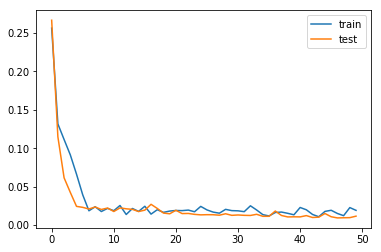

Test RMSE: 82.080


In [55]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

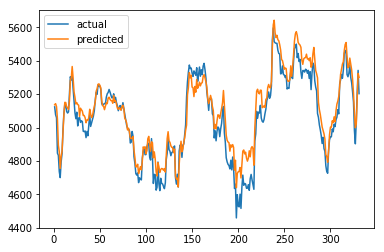

In [56]:
pyplot.plot(range(1,len(yhat)+1),inv_y,label='actual')
pyplot.plot(range(1,len(yhat)+1),inv_yhat,label='predicted')
pyplot.legend()
pyplot.show()


In [57]:
print(list(inv_y))

[5124.0, 5077.0, 5059.0, 4847.0, 4834.0, 4737.0, 4701.0, 4794.0, 4844.0, 4984.0, 5085.0, 5140.0, 5133.0, 5096.0, 5087.0, 5094.0, 5199.0, 5304.0, 5285.0, 5305.0, 5235.0, 5157.0, 5089.0, 5053.0, 5092.0, 5010.0, 5056.0, 5061.0, 5031.0, 5041.0, 5036.0, 4978.0, 4976.0, 4980.0, 4940.0, 4977.0, 4951.0, 5010.0, 5076.0, 5007.0, 5028.0, 5051.0, 5069.0, 5102.0, 5164.0, 5210.0, 5199.0, 5255.0, 5249.0, 5248.0, 5229.0, 5144.0, 5133.0, 5139.0, 5144.0, 5142.0, 5182.0, 5202.0, 5210.0, 5228.0, 5213.0, 5194.0, 5178.0, 5179.0, 5202.0, 5151.0, 5181.0, 5150.0, 5131.0, 5101.0, 5120.0, 5132.0, 5106.0, 5120.0, 5149.0, 5113.0, 5080.0, 5049.0, 5015.0, 4995.0, 4992.0, 4983.0, 4908.0, 4913.0, 4977.0, 4947.0, 4826.0, 4786.0, 4725.0, 4716.0, 4729.0, 4671.0, 4700.0, 4691.0, 4687.0, 4817.0, 4856.0, 4878.0, 4838.0, 4839.0, 4886.0, 4903.0, 4906.0, 4823.0, 4806.0, 4934.0, 4831.0, 4666.0, 4720.0, 4719.0, 4626.0, 4643.0, 4794.0, 4665.0, 4623.0, 4697.0, 4666.0, 4663.0, 4648.0, 4635.0, 4670.0, 4809.0, 4848.0, 4936.0, 4868.0,

In [58]:
print(list(inv_yhat))

[5136.431, 5143.1772, 5125.444, 5050.8506, 4894.584, 4855.7734, 4755.7617, 4827.5186, 4858.9214, 4964.969, 5078.4487, 5150.887, 5149.6255, 5123.7, 5120.945, 5108.3174, 5158.2153, 5280.7666, 5297.1, 5365.1636, 5296.016, 5213.9033, 5181.655, 5140.845, 5149.364, 5137.6646, 5134.2563, 5066.792, 5115.926, 5106.6255, 5098.339, 5072.3735, 5072.2427, 5059.077, 5028.839, 5045.74, 5043.6455, 5059.9565, 5109.5273, 5080.3447, 5059.6704, 5068.7285, 5101.824, 5127.636, 5153.472, 5217.513, 5232.348, 5258.906, 5261.396, 5252.917, 5237.9097, 5160.726, 5130.442, 5128.0464, 5107.161, 5126.397, 5147.63, 5142.6636, 5177.8228, 5181.7207, 5169.161, 5161.359, 5160.719, 5145.6084, 5192.158, 5156.328, 5161.6133, 5140.575, 5116.131, 5109.1313, 5119.6357, 5112.893, 5103.9487, 5127.48, 5133.7393, 5112.7817, 5056.005, 5046.0703, 5028.104, 4986.0063, 4996.4663, 4975.653, 4938.9497, 4933.389, 4939.219, 4946.3467, 4866.27, 4820.5723, 4764.782, 4766.1626, 4780.804, 4724.688, 4749.9087, 4766.6587, 4747.1963, 4796.664, 4